## GEORGIA Tutorial

This notebook provides a tutorial to run GEORGIA: a Graphic neural network based EmulatOR for Glacial Isostatic Adjustment

This tutorial will guide you through running GEORGIA, including loading emulator and data, emulate RSL and visulising emulation error. We will use 150-member testing set for this tutorial. A testing set denotes input and output examples which were not being used to train the emulator.

We also include two illustrative applications of using GEORGIA to investigate palaeo sea-level related problems: 

> **1. barystatic sea level calculator**

> **2. probabilistic barystatic sea level map**

### Module and data loading

In [1]:
#Import Modules
import torch
import numpy as np
import healpy as hp
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchmetrics import PeakSignalNoiseRatio,StructuralSimilarityIndexMeasure,UniversalImageQualityIndex,R2Score
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from deep_gia import *

#set default plotting style
font = {'weight':'normal',
       'size':16}
matplotlib.rcParams['figure.figsize'] = (20,10)
matplotlib.rc('font',**font)

In [2]:
#load GEORGIA
if torch.cuda.is_available():
    model = torch.load('./emulator/GIA_emulator').to('cuda') #for gpu users
else:
    model = torch.load('emulator/GIA_emulator').to('cpu') #for cpu users

#load data 
heal16_input_norm = np.load('data/healpix16_test_input_norm.npy')
heal16_input_mean = np.load('data/heal16_input_mean.npy')
heal16_input_std = np.load('data/heal16_input_std.npy')
heal16_input_ori = heal16_input_norm*heal16_input_std[None,:,None]+heal16_input_mean[None,:,None]
heal16_input_ori[:,:,-1] = 0 #convert all RSL prediction in modern to 0 

heal16_output_norm = np.load('data/healpix16_test_output_norm.npy')
heal16_output_mean = np.load('data/heal16_output_mean.npy')
heal16_output_std = np.load('data/heal16_output_std.npy')
heal16_output_ori = heal16_output_norm*heal16_output_std[None,:,None]+heal16_output_mean[None,:,None]

modern_topo = np.load('data/modern_topo_healpix16.npy')
modern_ice = np.load('data/ice_0_healpix16.npy')

#### Visulise mean and standard deviation input and output data (Supplementary FIgure 1)


/home/yucheng/anaconda3/lib/python3.9/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/home/yucheng/anaconda3/lib/python3.9/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/home/yucheng/anaconda3/lib/python3.9/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. T

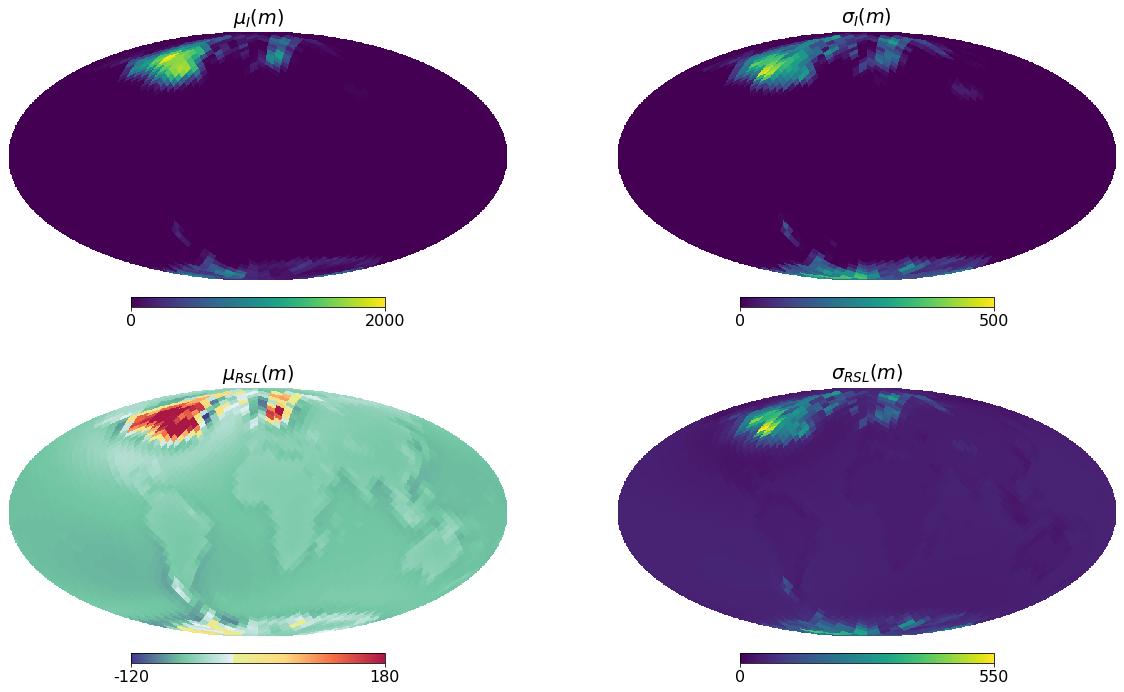

In [3]:
plt.figure(figsize=(20,12))
plt.subplot(221)
hp.mollview(heal16_input_mean,max=2000,min=0,hold=True,title='$\mu_{I} (m)$')
plt.subplot(222)
hp.mollview(heal16_input_std,max=500,min=0,hold=True,title='$\sigma_{I} (m)$')

plt.subplot(223)
new_cmap = gen_colormap()
hp.mollview(heal16_output_mean,max=180,min=-120,cmap = new_cmap,hold=True,title='$\mu_{RSL} (m)$')
plt.subplot(224)
hp.mollview(heal16_output_std,max=550,min=0,hold=True,title='$\sigma_{RSL} (m)$');

#### Emulate 150-member testing set 

In [4]:
#Eumulate test set 
test_predction = np.zeros([150,1,3072,26])
if torch.cuda.is_available():
    print('-------Emulation with GPU-------')
    heal16_output_std_test = torch.tensor(heal16_output_std)[None,None,:,None].cuda()
    X_test = torch.Tensor(heal16_input_norm)[:,None].cuda()
    y_test = torch.Tensor(heal16_output_norm)[:,None].cuda()
else:
    print('-------Emulation with CPU-------')
    heal16_output_std_test = torch.tensor(heal16_output_std)[None,None,:,None]
    X_test = torch.Tensor(heal16_input_norm)[:,None]
    y_test = torch.Tensor(heal16_output_norm)[:,None]

test_set = TensorDataset(X_test,y_test) # create your datset
test_dataloader = DataLoader(test_set, batch_size=1)

import time
print('-------Start emulation!---------')
total_time = 0
for batch, (X, y) in enumerate(test_dataloader):    
    if batch%10==0: print('-------'+str(batch)+' completed--------------')
    if torch.cuda.is_available():
        X, y = X.to('cuda'), y.to('cuda')
    start = time.time()
    pred = model(X)
    test_predction[batch*1:(batch+1)*1] = pred.cpu().detach().numpy()
    end = time.time()
    #Subtract Start Time from The End Time
    total_time += (end - start)
    del X
    del y

print('Average emulation speed: {0:3.3f} seconds per sample'.format(total_time/len(X_test)))
#convert normalised emulation output to original field 
test_predction = test_predction[:,0]*heal16_output_std[None,:,None]+heal16_output_mean[None,:,None]
test_predction[:,:,-1] = 0 #convert all RSL prediction in modern to 0 

# #save emulation prediction
# np.save('data/emulation_pred',test_predction)

-------Emulation with GPU-------
-------Start emulation!---------
-------0 completed--------------


/home/yucheng/anaconda3/lib/python3.9/site-packages/torch/_tensor.py:1090: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/c10/core/TensorImpl.h:1463.)
  return super(Tensor, self).rename(names)
/home/yucheng/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:651: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool1d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


-------10 completed--------------
-------20 completed--------------
-------30 completed--------------
-------40 completed--------------
-------50 completed--------------
-------60 completed--------------
-------70 completed--------------
-------80 completed--------------
-------90 completed--------------
-------100 completed--------------
-------110 completed--------------
-------120 completed--------------
-------130 completed--------------
-------140 completed--------------
Average emulation speed: 0.265 seconds per sample


### Emulation error visualization

Here we visulise the temporal and sptail distribution of emulation error by comparing emulated RSL by GEORGIA and simulated RSL by a physics-based GIA model. 

In [5]:
#heal16_output_ori denotes the simulated RSL from a physics-based GIA model

mae = np.mean(np.abs(heal16_output_ori-test_predction))
psnr = PeakSignalNoiseRatio()
psnr_result = psnr(torch.tensor(heal16_output_ori)[:,:,:], torch.tensor(test_predction[:,:,:]))
r2 = R2Score()
r2_score = r2(torch.tensor(heal16_output_ori)[:,:,:].flatten(), torch.tensor(test_predction[:,:,:].flatten()))

print('Mean Absolute Error: {0:3.3f} m'.format(mae))
print('Peak Signal to Noise Ratio: {0:3.3f}'.format(psnr_result))
print('R2 Score: {0:3.4f}'.format(r2_score))


Mean Absolute Error: 0.538 m
Peak Signal to Noise Ratio: 61.106
R2 Score: 0.9998


#### Visulise spaital distribution of emulated error (i.e., Figure 2a)


/home/yucheng/anaconda3/lib/python3.9/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/home/yucheng/anaconda3/lib/python3.9/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/home/yucheng/anaconda3/lib/python3.9/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.
  warnings.warn(


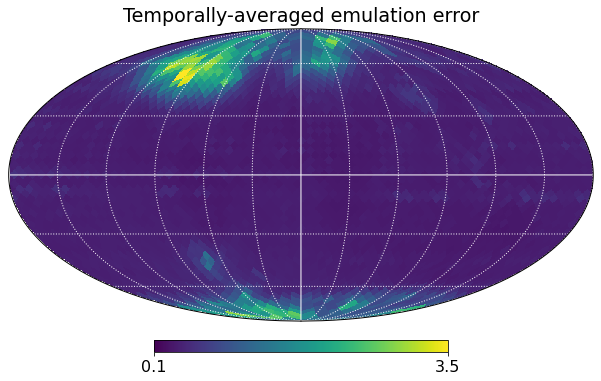

In [6]:
#calculate temporally averaged absolute error
spatial_mae = np.mean(np.mean(np.abs(heal16_output_ori-test_predction),axis=0),axis=1)
hp.mollview(spatial_mae,max=3.5,min=0.1,title='Temporally-averaged emulation error')
hp.graticule(color='w')

#save data
# np.save('data/spatial_mae',spatial_mae)

#### Visulise temporal distribution of emulated error (i.e., Figure 2b)


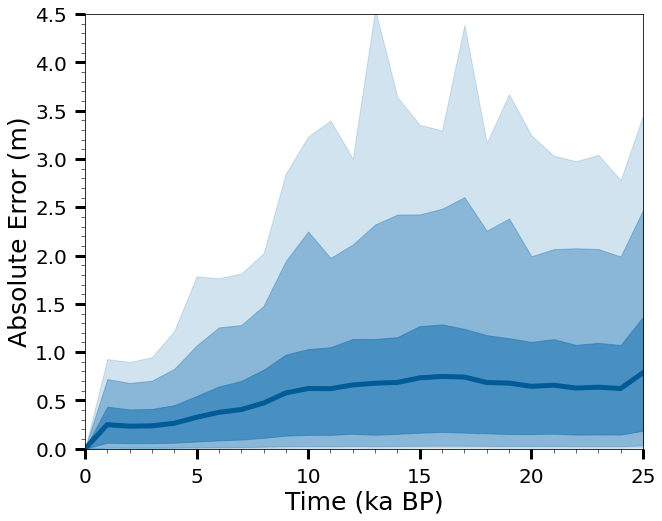

In [7]:
temporal_mae = np.mean(np.mean(np.abs(heal16_output_ori-test_predction),axis=0),axis=0)
#calculate confidence interval of emulation error across 150 testing set
down_mae,up_mae = np.percentile(np.abs(heal16_output_ori-test_predction),[16,84],axis=0)
down_mae2,up_mae2 = np.percentile(np.abs(heal16_output_ori-test_predction),[2.5,97.5],axis=0)
down_mae3,up_mae3 = np.percentile(np.abs(heal16_output_ori-test_predction),[0.5,99.5],axis=0)

#averaging across spatial domain
down_mae_mean = np.mean(down_mae,axis=0)
up_mae_mean = np.mean(up_mae,axis=0)
down_mae_mean2 = np.mean(down_mae2,axis=0)
up_mae_mean2 = np.mean(up_mae2,axis=0)
down_mae_mean3 = np.mean(down_mae3,axis=0)
up_mae_mean3 = np.mean(up_mae3,axis=0)

plt.figure(figsize=(10,8))
ax = plt.subplot(111)

ax.fill_between(np.arange(25,-1,-1),down_mae_mean3,up_mae_mean3,color='C0',alpha=0.2)
ax.fill_between(np.arange(25,-1,-1),down_mae_mean2,up_mae_mean2,color='C0',alpha=0.4)
ax.fill_between(np.arange(25,-1,-1),down_mae_mean,up_mae_mean,color='C0',alpha=0.6)
ax.plot(np.arange(25,-1,-1),temporal_mae,linewidth=5,color='#005b96')

ax.tick_params(labelsize=15, pad=8,which='major',direction='out',length=10,width=3)

ax.tick_params(which='minor', length=4, color='k')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlim(0,25)
ax.set_ylim(0,4.5)
ax.set_xlabel('Time (ka BP)',fontsize=25)
ax.set_ylabel('Absolute Error (m)',fontsize=25)
ax.minorticks_on()

#save stacked data
# import pandas as pd

# stack_data = np.vstack([np.arange(25,-1,-1),temporal_mae,down_mae_mean,up_mae_mean,down_mae_mean2,up_mae_mean2,down_mae_mean3,up_mae_mean3])
# stack_data = pd.DataFrame(stack_data,index=['Time (ka BP)','Mean MAE','16% percentile','64% percentile','2.5% percentile','97.5% percentile','0.5% percentile','99.5% percentile'])
# stack_data.to_csv('data/Temporal_error.csv')

#### Visulise error distribution by 2d histogram and cumulative probability distribution (i.e., Figure 2c)


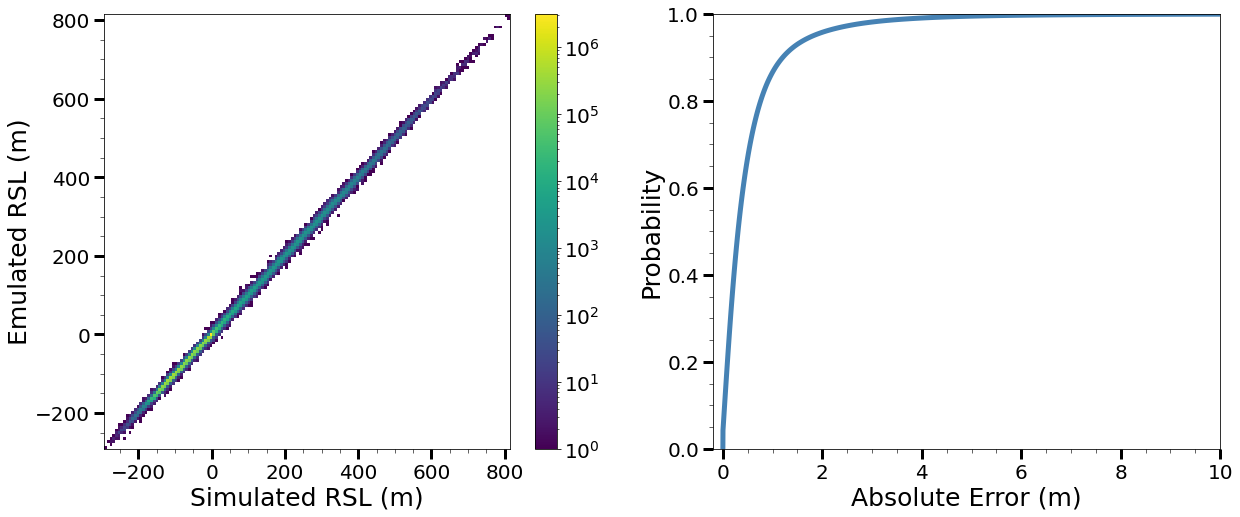

In [8]:
plt.figure(figsize=(20,8))
ax = plt.subplot(121)
plt.hist2d(heal16_output_ori.flatten(),(test_predction).flatten(),150, norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20) 

ax.tick_params(labelsize=15, pad=4,which='major',direction='out',length=10,width=3)
ax.tick_params(axis='both', which='major', labelsize=20)

ax.tick_params(which='minor', length=4, color='k')

ax.minorticks_on()
ax.set_xlabel('Simulated RSL (m)',fontsize=25)
ax.set_ylabel('Emulated RSL (m)',fontsize=25)

ax = plt.subplot(122)
sns.ecdfplot(np.abs(heal16_output_ori-test_predction).flatten(),ax=ax,
            linewidth=5,color='steelblue')
ax.tick_params(labelsize=15, pad=4,which='major',direction='out',length=10,width=3)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(which='minor', length=4, color='k')
ax.minorticks_on()
ax.set_xlabel('Absolute Error (m)',fontsize=25)
ax.set_ylabel('Probability',fontsize=25)
plt.xlim(-0.2,10);

#### Visulise Emulation error at three specific sites - Northern Massachusetts, Barbados and Seychelles (Figure 2d-f)

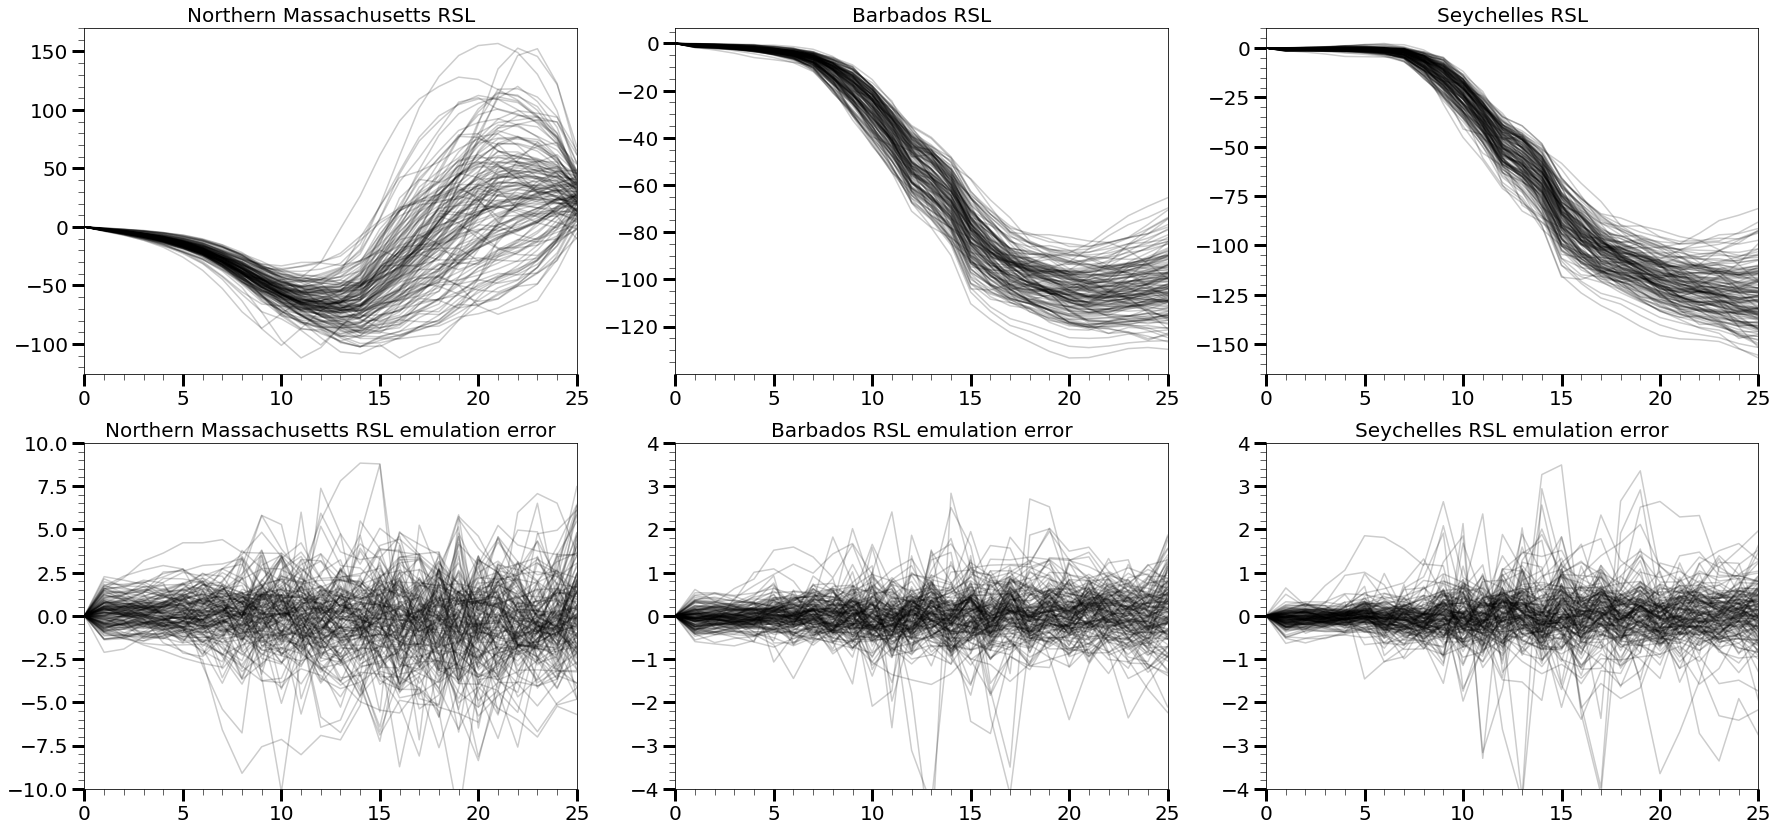

In [9]:
#set healpix indices for three loctions
NM_index = 492
Ba_index = 1130
Sey_index = 1686
coor_index = [NM_index,Ba_index,Sey_index]
titles = ['Northern Massachusetts','Barbados','Seychelles']
#calculate misfit matrix for each location
NM_misfit = (test_predction-heal16_output_ori)[:,NM_index]
Ba_misfit = (test_predction-heal16_output_ori)[:,Ba_index]
Sey_misfit = (test_predction-heal16_output_ori)[:,Sey_index]
misfit_list = [NM_misfit,Ba_misfit,Sey_misfit]
fig,axes = plt.subplots(2,3,figsize=(30,14))
for i,ax in enumerate(axes.flat):
    ax.tick_params(labelsize=15, pad=4,which='major',direction='out',length=12,width=3)
    ax.tick_params(which='minor', length=6, color='k')
    ax.minorticks_on()

    ax.set_xlim(0,25)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    if i<=2:
        for i2 in range(len(heal16_output_ori)):
            ax.plot(np.arange(25,-1,-1),heal16_output_ori[i2,coor_index[i],:],label='ground_true',color='k',
                   alpha=0.2,markersize=5)
        ax.set_title(titles[i]+' RSL',fontsize=20)
        
    else:
        for i2 in range(len(heal16_output_ori)):
            ax.plot(np.arange(25,-1,-1),misfit_list[i-3][i2,:],label='ground_true',color='k',
                   alpha=0.2,markersize=5)
        ax.set_title(titles[i-3]+' RSL emulation error',fontsize=20)
        if i==3: ax.set_ylim(-10,10)
        if i>3: ax.set_ylim(-4,4)

### Application 1: Barystatic sea-level calculator

In this study, we consider barystatic sea level as a direct indicator of global grounded ice volume through time ($BSL(t)$), which can be expressed as: 

\begin{equation}
    \label{eqn:ESL_cal}
    BSL(t) = - \frac{\rho_{ice}}{\rho_{water}}\left[\frac{V_{ice}(t)}{A_{ocean}(t)} - \frac{V_{ice}(t_{0})}{A_{ocean}(t_{0})}\right]
\end{equation}

where $\rho_{ice}$ and $\rho_{water}$ denote ice and ocean water density; $V_{ice}(t)$ and $A_{ocean}(t)$ represents global grounded ice volume and global ocean surface area at time $t$, and $t_0$ represents the present day. And grounded ice volume at each location and time ($v_{ice}(t,\varphi)$) can be calculated as:

\begin{equation}
\begin{split}
    \label{eqn:grounded_ice}
    v_{ice}(t,\varphi) = 
    \begin{cases}
    0, & i(t,\varphi)=0 \lor i(t,\varphi)<\frac{\rho_{water}}{\rho_{ice}}b(t,\varphi)\\
    v_{ice}(t,\varphi),& i(t,\varphi)\geq \frac{\rho_{water}}{\rho_{ice}}b(t,\varphi)\\
    \end{cases} \\
\end{split}
\end{equation}

where $i(t,\varphi)$ and $b(t,\varphi)$ denotes ice thickness and bathymetry (positive value in ocean) at location $\varphi$ and time $t$, and $b(t,\varphi)$ can be further expressed as: 
\begin{equation}
    \label{eqn:paleo_bath}
    b(t,\varphi) = b(t_{0},\varphi) + RSL(t,\varphi)
\end{equation}

where $RSL(t,\varphi)$ indicate RSL prediction either by a physical simulator or the statistical emulator introduced in this study.

One important concept that should be aware is the BSL used here is a measure of global grounded ice volume, which does not reflect the magnitude of the global mean sea-level rise if all grounded ice melts. This is due to the fact that some ice-sheet are marine-ground and hence the ice volume below flotation will not contribute to global sea-level rise. 

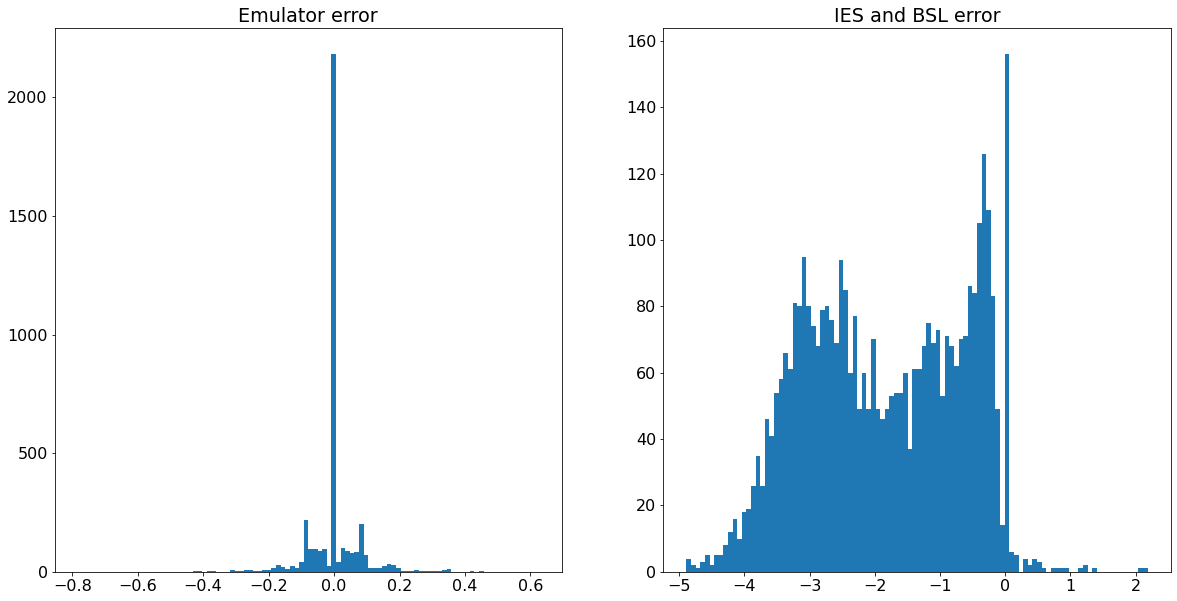

In [10]:
#calculate BSL and Ice Equivalent sea level (IES)
model_bsl2_all = [] #BSL with ground truth RSL prediction
ise_all = [] #BSL with ground emulated RSL prediction
emulate_bsl2_all = [] # IES with ground truth RSL prediction

for i in range(150):
    model_index =i
    #for functions related to calculate BSL and IES
    model_bsl2 = cal_all_bsl(modern_topo,modern_ice,heal16_output_ori[model_index],np.swapaxes(heal16_input_ori[model_index],0,1))
    emulate_bsl2 = cal_all_bsl(modern_topo,modern_ice,test_predction[i],np.swapaxes(heal16_input_ori[model_index],0,1))
    model_ies = cal_all_ise(np.swapaxes(heal16_input_ori[model_index],0,1))
    
    ise_all.append(model_ies)
    model_bsl2_all.append(model_bsl2)
    emulate_bsl2_all.append(emulate_bsl2)
    
ise_all = np.array(ise_all)
model_bsl2_all = np.array(model_bsl2_all)
emulate_bsl2_all = np.array(emulate_bsl2_all)
plt.figure()
plt.subplot(121)
plt.hist((model_bsl2_all-emulate_bsl2_all).flatten(),100)
plt.title('Emulator error')
plt.subplot(122)
plt.hist((model_bsl2_all-ise_all).flatten(),100)
plt.title('IES and BSL error');

### Application 2: Probabiblistic Barystatic Sea Level Map

Barystatic sea-level treasure map indicates locations where local relative sea-level can approximate global barystatic sea-level value at certain time slices. The determination of treasure map depends on the glacial isostatic adjustment (GIA) model estimates of the gravitational, rotational and deformational effects associated with ice-ocean mass exchange. 

As one of the main purposes of GEORGIA is to sample ice history uncertainty on the resulting relative sea level prediction, it is suitable for investigating the ice sheet spatio-temporal uncertainty impact on the barystatic sea level map.

The implememtation is straighforward： 

> 1. Calculate the non-barystatic signal by subtracting the RSL emulation outpus with the BSL estimates based on GEORGIA. 

> 2. Calculating the probability of non-barystatic signal to fall in a defined threhold (e.g., 3 m for LGM and 1 m for Mid-Holoceme). 

> 3. Applying a Gaussian filter to help the treasure map to maintain spatially smooth. 

**Note:** Here we only use the emulated relative sea level results for 150 test set to calculate the probabilistic sea level treasure map. Comparatively, Figure 4 in the paper is generated by 10,000 relative sea-level emulations of randomly generated ice histories. 

In [11]:
test_bsl_depart_pred = test_predction + model_bsl2_all[:,None,:] #1. calculate non-barystatic signal
test_bsl_map_pred_3m = np.mean(np.abs(test_bsl_depart_pred)<3,axis=0) #2. calculate the LGM probability
test_bsl_map_pred_1m = np.mean(np.abs(test_bsl_depart_pred)<1,axis=0) #3. calculate the mid-Holocene probability

smoothed_map = hp.sphtfunc.smoothing(test_bsl_map_pred_3m[:,5],sigma= 0.05) 
smoothed_map2 = hp.sphtfunc.smoothing(test_bsl_map_pred_1m[:,19],sigma= 0.05) #smooth the signal


/home/yucheng/anaconda3/lib/python3.9/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 171.887339 arcmin (0.050000 rad) 
  warnings.warn(
/home/yucheng/anaconda3/lib/python3.9/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 404.763750 arcmin
  warnings.warn(
/home/yucheng/anaconda3/lib/python3.9/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/yucheng/anaconda3/lib/python3.9/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


/home/yucheng/anaconda3/lib/python3.9/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/home/yucheng/anaconda3/lib/python3.9/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/home/yucheng/anaconda3/lib/python3.9/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. T

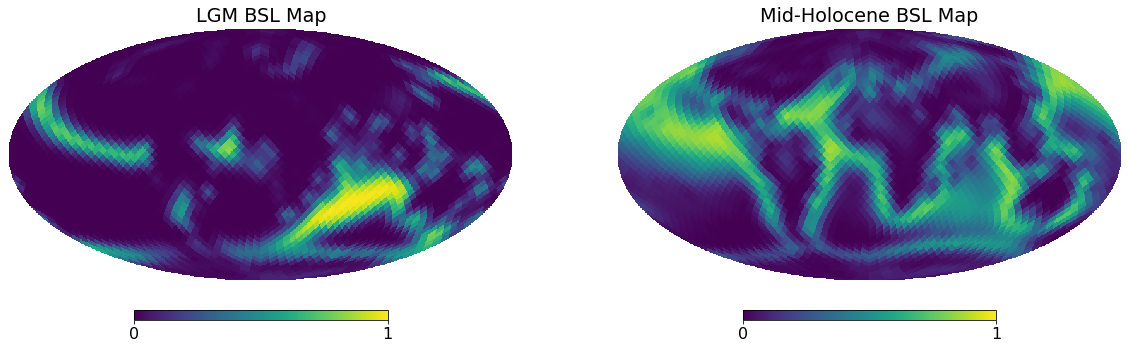

In [12]:
#Figure 3a,b
plt.subplot(121)
#A Gaussian filter is further applied here to make the map maintain smooth
hp.mollview(smoothed_map,max=1,min=0,cmap='viridis',hold=True,title='LGM BSL Map')

plt.subplot(122)
hp.mollview(smoothed_map2,max=1,min=0,cmap='viridis',hold=True,title='Mid-Holocene BSL Map');


### Finding non-barystatic signal at different locations

Based on the ensemble of non-barystatic signal calculated above, it would be possible to calculate the confidence interval of non-barystatic signal at different locations through time. Here we provide examples in six different locations where long-term sea-level records are available: Bonapart Gulf, Sunda Shelf, Barbados, Seychelles, Huon Peninsula, Tahiti. 

In [13]:
#find signal

sunda_95,sunda_68 = find_95and68(test_bsl_depart_pred[:,1484])
seychelles_95,seychelles_68 = find_95and68(test_bsl_depart_pred[:,1686])
bar_95,bar_68 = find_95and68(test_bsl_depart_pred[:,1130])
hu_95,hu_68 = find_95and68(test_bsl_depart_pred[:,1733])
tahiti_95,tahiti_68 = find_95and68(test_bsl_depart_pred[:,2042])
bonapart_95,bonapart_68 = find_95and68(test_bsl_depart_pred[:,1864])
GBR_95,GBR_68 = find_95and68(test_bsl_depart_pred[:,2053])

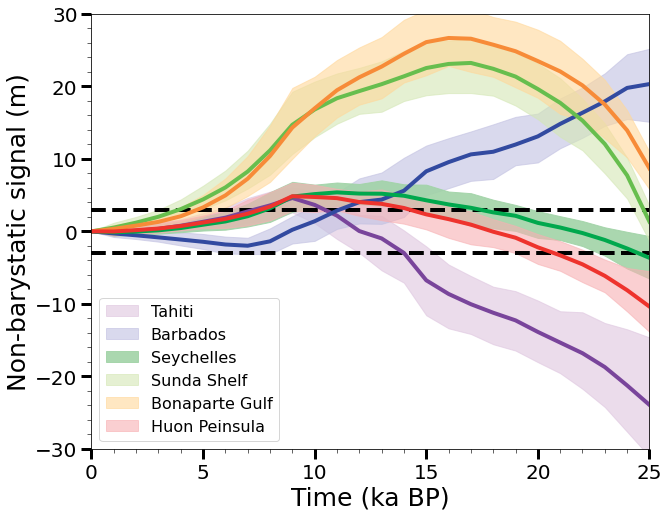

In [14]:
#Figure 3c
map_alpha=0.6
plt.figure(figsize=(10,8))
ax = plt.subplot(111)
ax.tick_params(labelsize=15, pad=4,which='major',direction='out',length=10,width=3)
ax.tick_params(which='minor', length=4, color='k')
ax.minorticks_on()

plt.plot(np.arange(25,-1,-1),np.mean(test_bsl_depart_pred[:,2042],axis=0),color='#79459b',
        lw=4)
plt.fill_between(np.arange(25,-1,-1),tahiti_95[:,0],tahiti_95[:,1],alpha=map_alpha,
                zorder=1,label='Tahiti',color='#dec5df')

plt.plot(np.arange(25,-1,-1),np.mean(test_bsl_depart_pred[:,1130],axis=0),color='#324aa0',
        lw=4)
plt.fill_between(np.arange(25,-1,-1),bar_95[:,0],bar_95[:,1],alpha=map_alpha,
                zorder=1,label='Barbados',color='#c1c0e1')

plt.plot(np.arange(25,-1,-1),np.mean(test_bsl_depart_pred[:,1686],axis=0),color='#00a84d',
        lw=4)
plt.fill_between(np.arange(25,-1,-1),seychelles_95[:,0],seychelles_95[:,1],alpha=0.9
                ,label='Seychelles',color='#a1d3a7')

plt.plot(np.arange(25,-1,-1),np.mean(test_bsl_depart_pred[:,1484],axis=0),color='#67be4e',
        lw=4)
plt.fill_between(np.arange(25,-1,-1),sunda_95[:,0],sunda_95[:,1],alpha=map_alpha,
                zorder=1,label='Sunda Shelf',color='#d4e7b5')

plt.plot(np.arange(25,-1,-1),np.mean(test_bsl_depart_pred[:,1864],axis=0),color='#f78b38',
        lw=4)
plt.fill_between(np.arange(25,-1,-1),bonapart_95[:,0],bonapart_95[:,1],alpha=map_alpha,
                zorder=1,label='Bonaparte Gulf',color='#ffd89a')

plt.plot(np.arange(25,-1,-1),np.mean(test_bsl_depart_pred[:,1733],axis=0),color='#ee332d',
        lw=4)
plt.fill_between(np.arange(25,-1,-1),hu_95[:,0],hu_95[:,1],alpha=map_alpha,
                zorder=1,label='Huon Peinsula',color='#f8b0b3')

plt.hlines(3,0,25,color='k',linestyle='--',lw=4)
plt.hlines(-3,0,25,color='k',linestyle='--',lw=4)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(loc=3)
plt.xlim(0,25)
plt.ylim(-30,30)
plt.xlabel('Time (ka BP)',fontsize=25)
plt.ylabel('Non-barystatic signal (m)',fontsize=25);